# Première version de l'autoencodeur simple sur le petit jeu de données Olivetti faces

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split

## Chargement du dataset et formatage des données

In [5]:
# Charger le dataset Olivetti Faces
dataset = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = dataset.images, dataset.target  # X contient les images, y contient les labels


# Conversion des données en tenseurs
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)

# Création d'un dataset PyTorch
tensor_dataset = TensorDataset(X_tensor, y_tensor)

# Séparation en train/test (80% entraînement, 20% test)
train_size = int(0.8 * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size
train_dataset, test_dataset = random_split(tensor_dataset, [train_size, test_size])

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Création des DataLoaders
loader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)

## Autoencodeur
réseau de neurones convolutif

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (batch, 16, 32, 32)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (batch, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch, 64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2)
        )
        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 16, 32, 32)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 1, 64, 64)
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        """Extraction espace latent"""
        return self.encoder(x)


In [7]:
model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

## Entrainement du modèle

Epoch 1/20, Loss: 0.029176
Epoch 2/20, Loss: 0.019172
Epoch 3/20, Loss: 0.016199
Epoch 4/20, Loss: 0.013412
Epoch 5/20, Loss: 0.012525
Epoch 6/20, Loss: 0.010859
Epoch 7/20, Loss: 0.009603
Epoch 8/20, Loss: 0.008883
Epoch 9/20, Loss: 0.008016
Epoch 10/20, Loss: 0.008746
Epoch 11/20, Loss: 0.007050
Epoch 12/20, Loss: 0.007796
Epoch 13/20, Loss: 0.008360
Epoch 14/20, Loss: 0.007007
Epoch 15/20, Loss: 0.007665
Epoch 16/20, Loss: 0.007414
Epoch 17/20, Loss: 0.006425
Epoch 18/20, Loss: 0.006465
Epoch 19/20, Loss: 0.007843
Epoch 20/20, Loss: 0.006505


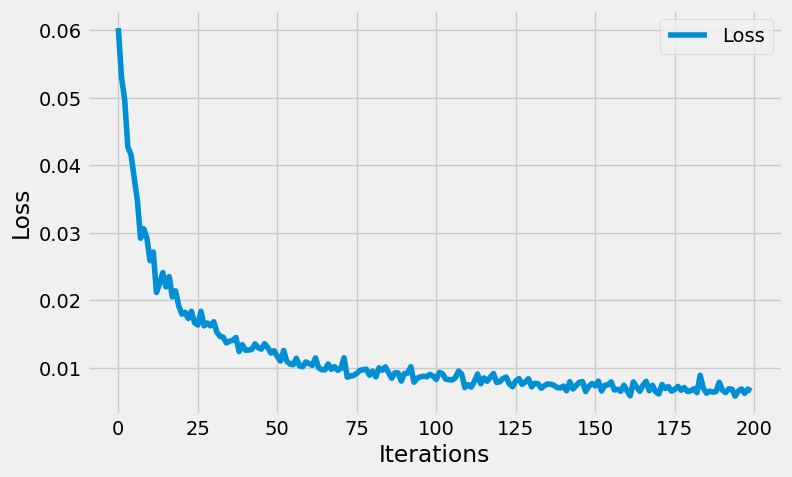

In [8]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.to(device)
        
        reconstructed = model(images)
        #loss = loss_function(reconstructed, images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation du modèle

In [ ]:
model.eval()
test_loss = 0

with torch.no_grad():  # Pas besoin de calculer les gradients
    for images, _ in test_loader:
        images = images.to(device)
        reconstructed = model(images)
        
        loss = loss_function(reconstructed, images)  # Ex: nn.MSELoss()
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.6f}")

dataiter = iter(test_loader)
images, _ = next(dataiter)

images = images.to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')
plt.show()

Test Loss: 0.003649
